In [2]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')



df = Loading_data.Get_Nacion()
df.head()

,Lugar,Casos,Casos hoy absoluto,Casos hoy variacion respecto ayer,Casos hoy porcentaje,Fallecidos,Fallecidos hoy absoluto,Fallecidos hoy variacion respecto ayer,Fallecidos hoy porcentaje,Tasa Mortalidad,Curados,Curados hoy absoluto,Casos excluidos curados,Proporcion Curados / Casos,UCI,Hospitalizados
Fecha,,,,,,,,,,,,,,,,
2020-04-10,España,157022,4576,-1180,0.029142,15843,605,-78,0.038187,0.100897,55668,3503.0,101354,0.354524,7482,67572
2020-04-09,España,152446,5756,-424,0.037758,15238,683,-74,0.044822,0.099957,52165,4144.0,100281,0.342187,7420,66579
2020-04-08,España,146690,6180,702,0.042130,14555,757,14,0.052010,0.099223,48021,4813.0,98669,0.327364,7132,63516
2020-04-07,España,140510,5478,1205,0.038987,13798,743,106,0.053848,0.098199,43208,2771.0,97302,0.307508,7069,63093
2020-04-06,España,135032,4273,-1750,0.031644,13055,637,-37,0.048794,0.096681,40437,2357.0,94595,0.299462,6931,59662


In [185]:
import pandas as pdg

momo = pd.read_csv('https://momo.isciii.es/public/momo/data')


array(['nacional', 'ccaa'], dtype=object)

In [203]:
def get_momo():
    return pd.read_csv('https://momo.isciii.es/public/momo/data')

def get_momo_by_year():
    kk = get_momo()

    # Enrich data
    kk = kk[(kk['ambito']=='nacional') &  (kk['nombre_gedad']=='todos')  &    (kk['nombre_sexo' ] =='todos') ]
    kk['date'] =kk['fecha_defuncion'] 
    kk['date'] = pd.to_datetime(kk['date'])
    kk['year'], kk['month'] = kk['date'].dt.year, kk['date'].dt.month
    kk["month"] = kk.month.map("{:02}".format)

    kk['year-month'] =  kk['year'].astype(str) + "-" +  kk['month'].astype(str)

    ss = kk[['defunciones_observadas','year-month']].groupby(['year-month'])['defunciones_observadas'].agg('sum').to_frame()
    ss['month'] = ss.index.astype(str).str[5:7] 
    ss['year-month'] = ss.index

    muertes_2018 = ss[(ss['year-month'] >= '2018-01') & (ss['year-month'] < '2019-01')][['defunciones_observadas','month']]
    muertes_2019 = ss[(ss['year-month'] >= '2019-01') & (ss['year-month'] < '2020-01')][['defunciones_observadas','month']]
    muertes_2020 = ss[(ss['year-month'] >= '2020-01') & (ss['year-month'] < '2021-01')][['defunciones_observadas','month']]

    muertes_2018=muertes_2018.rename(columns = {'defunciones_observadas':'2018'})
    muertes_2019=muertes_2019.rename(columns = {'defunciones_observadas':'2019'})
    muertes_2020=muertes_2020.rename(columns = {'defunciones_observadas':'2020'})


    muertes_2018 = muertes_2018.reset_index(drop=True)
    muertes_2019 = muertes_2019.reset_index(drop=True)
    muertes_2020 = muertes_2020.reset_index(drop=True)

    muertes_temp = pd.merge(  muertes_2019,muertes_2018, on="month", how='left')
    muertes_temp
    muertes_temp2 =  pd.merge(  muertes_2019,muertes_2020, on="month", how='left')
    muertes_temp2
    muertes_totales = pd.merge(  muertes_temp, muertes_temp2)
    muertes_totales.index=muertes_totales
    muertes_totales.index =muertes_totales['month'] 
    del muertes_totales['month']
    return muertes_totales[['2018','2019','2020']]

df=get_momo_by_year()

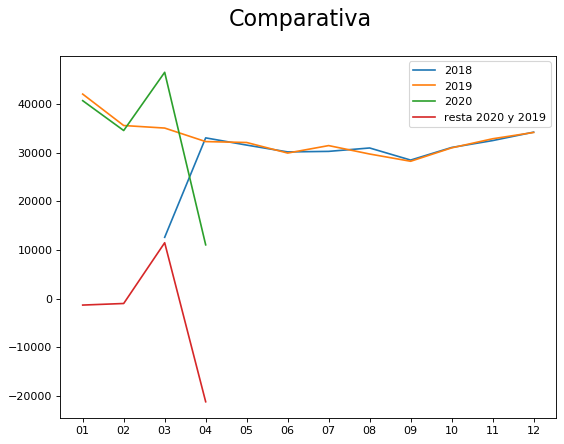

,2018,2019,2020,resta 2020 y 2019
month,,,,
01,NaN,42033,40683.0,-1350.0
02,NaN,35570,34543.0,-1027.0
03,12581.0,35049,46516.0,11467.0
04,33032.0,32268,11037.0,-21231.0
05,31547.0,32080,NaN,NaN
06,30142.0,29907,NaN,NaN
07,30254.0,31444,NaN,NaN
08,30953.0,29712,NaN,NaN
09,28465.0,28220,NaN,NaN


In [206]:
from matplotlib import pyplot as plt    
from IPython.display import display, HTML
import pandas as pd

import numpy as np


fig = plt.figure(figsize=(8, 6), dpi=80)
for ca in df.columns:
    plt.plot(df[ca])
    plt.legend(df.columns)
    fig.suptitle('Comparativa', fontsize=20)
plt.show()

df['resta 2020 y 2019'] = df['2020'] - df['2019']
df

In [205]:
nacional = momo[
    (momo['ambito'      ] =='nacional')    &
    (momo['nombre_gedad'] =='todos') &   
    (momo['nombre_sexo' ] =='todos')]
nacional

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99
0,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-03-21,1199,1199.000000,1199.000000,1139.00,1019.105,1279.955
1,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-03-22,1141,1141.000000,1141.000000,1130.75,1019.105,1249.325
2,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-03-23,1152,1152.000000,1152.000000,1120.00,1014.140,1249.325
3,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-03-24,1155,1155.000000,1155.000000,1119.50,1008.450,1249.325
4,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-03-25,1065,1065.000000,1065.000000,1122.00,1008.450,1230.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,nacional,NaN,NaN,NaN,all,todos,all,todos,2020-04-03,1730,1705.321074,1755.241699,1106.00,1003.380,1213.395
745,nacional,NaN,NaN,NaN,all,todos,all,todos,2020-04-04,1543,1512.702050,1574.920010,1098.00,1003.380,1203.735
746,nacional,NaN,NaN,NaN,all,todos,all,todos,2020-04-05,1538,1503.179159,1572.488110,1095.50,1003.380,1203.735
747,nacional,NaN,NaN,NaN,all,todos,all,todos,2020-04-06,1415,1358.357014,1472.400305,1094.50,1017.800,1189.030
